# Automating ADR/ORD Arbitrage Technical Analysis
This project automates the basic technical analysis required to partake in arbitrage trading. Arbitrage is, in theory, a risk-free trading strategy that uses high volume trades to profit off of temporary price discrepancies in equivalent stocks or stock bundles. ADR/ORD arbitrage focuses on the discrepancy between an American Depository Receipt (ADR) and its corresponding Ordinary share (ORD) in a foreign market. By swapping these two items through a depository institution, someone can "buy low, sell high" if the price difference is large enough.

## 1. User Input 
We begin by asking the user for basic information regarding their trading constraints and securities of interest. The cell below requests 9 pieces of information. Detailed information of each piece follows.<br><br><br>
ADR ticker: This is the symbol, consisting of a few letters, that specifies the ADR of interest.<br><br>
ORD ticker: This is the symbol, consisting of a few letters, a semi-colon, and a market code, that specifies the ORD of interest and the market it trades in.<br><br>
Currency pairings ticker: This is the symbol, consisting of a few letters, that specifies the currency of the foreign country followed by USD. <br><br>
Date of interest: This date must be in 'YYYY-MM-DD' format, and must be within the past two calendar days. As such, this program cannot run on a sunday or monday, because the API requests will be out of scope.<br><br>
ORD market time zone: This is the time zone of the stock exchange that the ORD is traded on. Refer to https://en.wikipedia.org/wiki/List_of_tz_database_time_zones for the specific code. <br><br>
ORD/ADR component ratio: Some ADRs represent multiple shares of their ORD counterpart. Enter the amount of shares 1 ADR represents.<br><br>
Depository rate: Enter the cheapest available depository swap fee; the commision for swapping an ADR to ORD and vice versa.<br><br>
Transaction speed: Enter a numerical value representing the approximate swaps per minute that you can achieve.<br><br>
Bundle size: Many depository institutions provide bundled swaps, so enter the size of your bundle that you trade with; how many shares at a time can you trade?<br><br>

In [11]:
%%capture
pip install alpha_vantage pandas

In [12]:
import ipywidgets as widgets
import warnings
#ignore plot warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display
#for markdown printing
def printmd(string):
    display(Markdown(string))
printmd("**Stock Pair Information**")
printmd("Fill out the following boxes to specify the ADR/ORD pairs of interest, the parameters surrounding them, and your personal restrictions.")

#create each widget, give it text assignments for info
ADR = widgets.Text(placeholder='ex: BB for Blackberry',description='ADR ticker:',style={'description_width': 'initial'})
display(ADR)
ORD = widgets.Text(placeholder='ex: BB:CN for Blackberry',description='ORD ticker:',style={'description_width': 'initial'})
display(ORD)
Currency = widgets.Text(placeholder='ex: CADUSD for Blackberry',description='Currency pairings ticker:',style={'description_width': 'initial'})
display(Currency)
Date = widgets.Text(placeholder='ex: 2021-03-26 (must be within 2 calendar days)',description='Date of interest:',style={'description_width': 'initial'})
display(Date)
time = widgets.Text(value='America/New_York',description='ORD market time zone:',style={'description_width': 'initial'})
display(time)
ratio = widgets.FloatText(value=1,description="ORD/ADR component ratio:",style={'description_width': 'initial'})
display(ratio)
Rate = widgets.FloatText(value=0.10,description="Depository Rate:",style={'description_width': 'initial'})
display(Rate)
speed = widgets.FloatText(value=2,description="Transaction speed:",style={'description_width': 'initial'})
display(speed)
Bundle = widgets.FloatText(value=100,description="Bundle size:",style={'description_width': 'initial'})
display(Bundle)

**Stock Pair Information**

Fill out the following boxes to specify the ADR/ORD pairs of interest, the parameters surrounding them, and your personal restrictions.

Text(value='', description='ADR ticker:', placeholder='ex: BB for Blackberry', style=DescriptionStyle(descript…

Text(value='', description='ORD ticker:', placeholder='ex: BB:CN for Blackberry', style=DescriptionStyle(descr…

Text(value='', description='Currency pairings ticker:', placeholder='ex: CADUSD for Blackberry', style=Descrip…

Text(value='', description='Date of interest:', placeholder='ex: 2021-03-26 (must be within 2 calendar days)',…

Text(value='America/New_York', description='ORD market time zone:', style=DescriptionStyle(description_width='…

FloatText(value=1.0, description='ORD/ADR component ratio:', style=DescriptionStyle(description_width='initial…

FloatText(value=0.1, description='Depository Rate:', style=DescriptionStyle(description_width='initial'))

FloatText(value=2.0, description='Transaction speed:', style=DescriptionStyle(description_width='initial'))

FloatText(value=100.0, description='Bundle size:', style=DescriptionStyle(description_width='initial'))

In [13]:
#User input cell
#SU (Suncor Energy), BB (Blackberry)
#assign internal references for each widget input
ADRticker = ADR.value
ORDticker = ORD.value
ORDtickerL = ORDticker.lower()
currencyPair = Currency.value
ORDtoADRratio = ratio.value
date=Date.value
ORDtimezone = time.value
depositoryFee = Rate.value
transactionSpeed = speed.value
bundledOrder=Bundle.value

## 2. Data Gathering and Wrangling
To begin our technical analysis, we need to gather data. This program queries the Bloomberg Rest API and the AlphaVantage API to gather available pricing info for the ADR, ORD, and the currency spot rate between them. The resulting main table combines the pricing data, and provides the technical analysis necessary for trading; this table shows the price discrepancy that is above and beyond the depository rate, and how long it persists for.

In [14]:
import requests
import pandas as pd
import numpy as np
import datetime
from alpha_vantage.timeseries import TimeSeries
from datetime import timedelta
#query the bloomberg API with my rapidapi access key and the ticker parameters given by the user
def extract_ticks(interval="d3"):
    url="https://bloomberg-market-and-financial-news.p.rapidapi.com/market/get-chart"
    querystring = {"interval":interval,"id":ORDtickerL}
    headers = {
        'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com",
        'x-rapidapi-key': "a9c1a0fd09mshaa4b315ca3eb637p193f28jsne624cf887b59"
        }
    response = requests.request("GET", url, headers=headers, params=querystring)
    json_d = response.json()
    return json_d
#Get year to date data
json_d = extract_ticks()
import json
with open("ORD_data.json","w") as fp:
    json.dump(json_d,fp)
with open("ORD_data.json","r") as fp:
    json_d = json.load(fp)
ticks_d = json_d['result'][ORDticker]['ticks']
#assign the data dump to a pandas dataframe
df = pd.DataFrame(ticks_d)
df['Close'] = df['close']
#set a datetime index
df['Date'] = df['time'].apply(lambda x:datetime.datetime.fromtimestamp(x))
df = df.set_index('time')
data = df.sort_index(ascending=True, axis=0)
#creating a separate dataset for cleanliness
ORDdata = data[['Date','Close']]
ORDdata['date'] = pd.to_datetime(ORDdata.Date,format='%Y-%m-%d')
ORDdata['ORDprice'] = ORDdata['Close']
ORDdataM = ORDdata[['date','ORDprice']]
ORDdataM=ORDdataM.set_index('date')
#adjust the ORD data into the component ratio
if (ORDtoADRratio!=1):
    ORDdataM[['ORDprice']]=ORDdataM[['ORDprice']]*ORDtoADRratio
ORDdataM.index = ORDdataM.index.tz_localize(ORDtimezone).tz_convert('America/New_York').tz_localize(None)
#cut data to the specified date and market hours
ORDdataM=ORDdataM.loc[date]
ORDdataM=ORDdataM.between_time('9:30','16:00')
#upsample to minutewise data
ORDdataM = ORDdataM.resample('min').ffill()
#ORDdataM

In [15]:
AVapi_key = "3MOF5LAA9RWBGJ3N"
#query the AlphaVantage API for ADR pricing data
ts = TimeSeries(key = AVapi_key,output_format = "pandas")
ADRdata, metadata = ts.get_intraday(symbol = ADRticker,interval= "1min" , outputsize = "full")
ADRdata['ADRprice']=ADRdata['4. close']
ADRdataM=ADRdata[['ADRprice']]
#cut data to the specified date and market hours
ADRdataM=ADRdataM.loc[date]
ADRdataM=ADRdataM.between_time('9:30','16:00')
#upsample for any missing data points
ADRdataM = ADRdataM.resample('min').ffill()
#ADRdataM

In [16]:
#query the AlphaVantage API for currency pricing data
ts = TimeSeries(key = AVapi_key,output_format = "pandas")
currencydata, metadata = ts.get_intraday(symbol = currencyPair,interval= "1min" , outputsize = "full")
currencydata.sort_values(by='date',ascending=True)
currencydata['exchangeSpot']=currencydata['4. close']
currencydataM=currencydata[['exchangeSpot']]
currencydataM.index = currencydataM.index.tz_localize('UTC').tz_convert('America/New_York').tz_localize(None)
#cut data to the specified date and market hours
currencydataM=currencydataM.loc[date]
currencydataM=currencydataM.between_time('9:30','16:00')
currencydataM = currencydataM.resample('min').ffill()
#the following line is just for testing time adjustments
#currencydataM.index = currencydataM.index-datetime.timedelta(days=3)
#currencydataM

In [17]:
#create the main table
merge1=pd.merge(currencydataM,ADRdataM, how='inner', left_index=True, right_index=True)
merge2=pd.merge(merge1,ORDdataM, how='inner', left_index=True, right_index=True)
#ORD price in USD
merge2['ORDpriceAdj']=merge2.ORDprice*merge2.exchangeSpot
#nominal price difference
merge2['PriceDiff']=merge2.ADRprice - merge2.ORDpriceAdj
#magnitude of price difference
merge2['AbsPriceDiff']=abs(merge2.PriceDiff)
#price discrepancy in excess of the depository rate; profitable difference
merge2['PriceDiffw/DepFee']=merge2.AbsPriceDiff-depositoryFee
#capturable separation is the nonzero values of price differences in excess of the depository rate
merge2['CapturableSeparation']=merge2['PriceDiffw/DepFee']
merge2.CapturableSeparation=merge2.CapturableSeparation.mask(merge2.CapturableSeparation.lt(0),0)
#per minute profit is the capturable separation times the bundle size and trade frequency
merge2['MinutewiseProfit']=merge2['CapturableSeparation']*transactionSpeed*bundledOrder
#total profit for the day
merge2['TotalProfit']=merge2['MinutewiseProfit'].cumsum()
merge2

,exchangeSpot,ADRprice,ORDprice,ORDpriceAdj,PriceDiff,AbsPriceDiff,PriceDiffw/DepFee,CapturableSeparation,MinutewiseProfit,TotalProfit
date,,,,,,,,,,
2021-05-03 09:30:00,0.8141,8.8600,10.84,8.824844,0.035156,0.035156,0.005156,0.005156,1.0312,1.0312
2021-05-03 09:31:00,0.8140,8.8900,10.84,8.823760,0.066240,0.066240,0.036240,0.036240,7.2480,8.2792
2021-05-03 09:32:00,0.8140,8.8644,10.84,8.823760,0.040640,0.040640,0.010640,0.010640,2.1280,10.4072
2021-05-03 09:33:00,0.8141,8.8300,10.84,8.824844,0.005156,0.005156,-0.024844,0.000000,0.0000,10.4072
2021-05-03 09:34:00,0.8142,8.8100,10.84,8.825928,-0.015928,0.015928,-0.014072,0.000000,0.0000,10.4072
...,...,...,...,...,...,...,...,...,...,...
2021-05-03 15:51:00,0.8140,8.6050,10.58,8.612120,-0.007120,0.007120,-0.022880,0.000000,0.0000,64.5600
2021-05-03 15:52:00,0.8142,8.6100,10.58,8.614236,-0.004236,0.004236,-0.025764,0.000000,0.0000,64.5600
2021-05-03 15:53:00,0.8139,8.6050,10.58,8.611062,-0.006062,0.006062,-0.023938,0.000000,0.0000,64.5600


## 3. Visual Analysis of Price Discrepancies
To provide the user some visual context for these price discrepancies, the following graphs are produced. First, we see a graph of the nominal price differences with horizontal lines indicating the depository rate. The next graph provides us similar information, instead showing the absolute value of the price differences; the magnitude of separation. The third graph from the following cell shows the magnitude of capturable separation; that is, the separation exceeding the depository rate, and thus, is profitable.

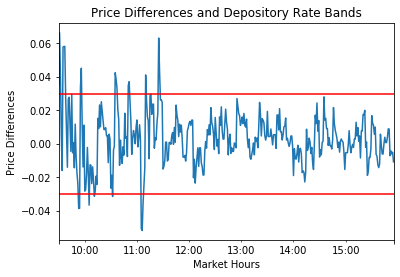

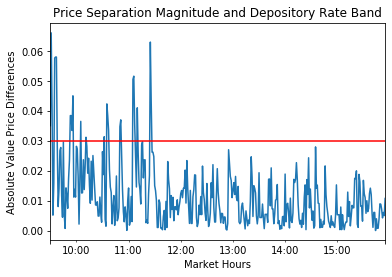

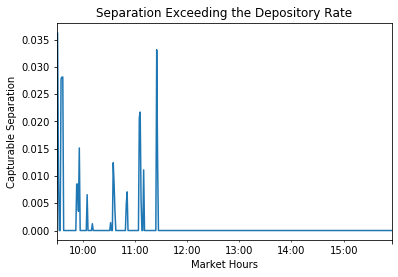

In [18]:
import matplotlib.pyplot as plt

#plots to show different columns of merge2; the data table
PriceSep=merge2['PriceDiff'].plot()
PriceSep.set_xlabel('Market Hours')
PriceSep.set_ylabel('Price Differences')
plt.axhline(y=-depositoryFee, color='r', linestyle='-')
plt.axhline(y=depositoryFee, color='r', linestyle='-')
plt.title('Price Differences and Depository Rate Bands')
plt.show()

absPriceSep=merge2['AbsPriceDiff'].plot()
absPriceSep.set_xlabel('Market Hours')
absPriceSep.set_ylabel('Absolute Value Price Differences')
plt.axhline(y=depositoryFee, color='r', linestyle='-')
plt.title('Price Separation Magnitude and Depository Rate Band')
plt.show()

capturableSep=merge2['CapturableSeparation'].plot()
capturableSep.set_xlabel('Market Hours')
capturableSep.set_ylabel('Capturable Separation')
plt.title('Separation Exceeding the Depository Rate')
plt.show()

### 3.1 Persistence of Separation / Risk Analysis
The following two graphs are the most important for our visual analysis of this arbitrage opportunity. These graphs are illustrating the magnitude of price separation and the amount of time it takes for the separations to close against the chronological moments of separation, respectively.<br><br> 
These two graphs allow for the visualization of the longevity of this trading strategy. The first graph also displays a horizontal line for the average magnitude of cost-excess price discrepancies for the day. If the graph has a few spikes and tends to lie far below this line, that is indicative of a volatility shock; the spikes in price discrepancies suggest large orders moving the market price, and thus, the observed discrepancy was a rare occurence and you cannot expect to profit long-term. On the other hand, if there is a stable fluctuation about the red line, there is a systematic oversight of the pricing of this stock, and you have the potential to hit it big. <br>
The second graph displays the longevity of your ability to trade at a fast enough rate to capture separation. In this graph, the red line represents your maximum transaction speed threshold. As such, if the graph frequently stays above the red line, you can trade at a fast enough rate to avoid the risk of accidental exposure. If the graph is mostly below the red line, however, your threshold is too slow to consistently avoid accidental exposure. To demonstrate accidental exposure, imagine the ADR is trading below the ORD. You might buy the ADR, swap to ORD, but in the time it took you to make the swap, the price discrepancy closed. This would cause you to lose the transaction cost (depository rate), and make no profit.

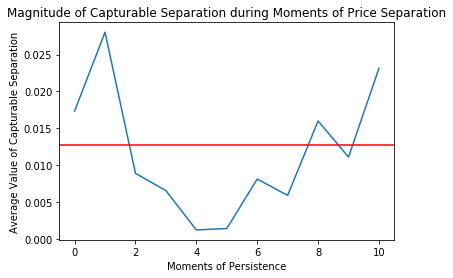

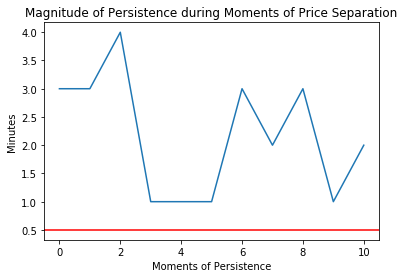

In [19]:
merge3=merge2.reset_index()
#identify the consecutive blocks of non-zero values using boolean masking and cumsum
m = merge3['CapturableSeparation'].eq(0)
b = m.cumsum()[~m]
agg_dict = dict(persistence=('date', np.ptp), 
                avgvalue=('CapturableSeparation', 'mean'))
#produce a table that combines the calculation of the time that non-zero values persist for
#group it with the average value of the magnitude of separation
out = merge3.groupby(b, as_index=False).agg(**agg_dict)
out['persistence'] += pd.Timedelta(minutes=1)
out['persistenceMin']=out['persistence']
for col in out:
    if col=='avgvalue':
        continue
    elif col=='persistence':
        continue
    for i, row_value in out[col].iteritems():
        out[col][i]=row_value.total_seconds()/60
        
#plot the persistence table by moments of persistence; first moment of persistent separation against either avg magnitude or time before closing
persistence=out['avgvalue'].plot()
persistence.set_xlabel('Moments of Persistence')
persistence.set_ylabel('Average Value of Capturable Separation')
plt.axhline(y=out['avgvalue'].sum()/int(len(out.index)-1), color='r', linestyle='-')
plt.title('Magnitude of Capturable Separation during Moments of Price Separation')
plt.show()

persistence=out['persistenceMin'].plot()
persistence.set_xlabel('Moments of Persistence')
persistence.set_ylabel('Minutes')
plt.axhline(y=1/transactionSpeed, color='r', linestyle='-')
plt.title('Magnitude of Persistence during Moments of Price Separation')
plt.show()

## 4. Profit Potential
After looking going through our risk analysis, we know have an idea of the amount of risk this strategy would incur. So, we can begin to look at the estimates of the profit we expect to make using this strategy. The nominal estimate is simply the sum of the minute-wise profit from the table we made. The minute-wise profit is calculated by taking the magnitude of price separation in excess of the depository rate, and multiplying that by the trades per minute transaction speed and the bundle size.<br><br>
The following graph is another visual cue of the longevity of this trading strategy. The perfect graph would show total profit as a 45 degree line from the origin, which would suggest you consistently make returns throughout the day. Instead, we see that the majority of the profit incurred results from large spikes in separation that occur infrequently, meaning this ADR/ORD pair likely will only be profitable in the short term.

In [20]:
#daily profit
merge2['MinutewiseProfit'].sum()

64.55999999999923

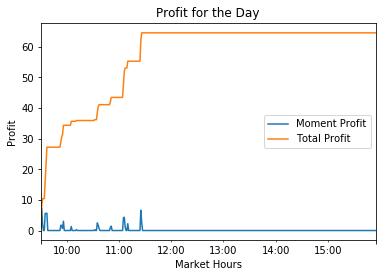

In [21]:
#Graph daily profit versus minute profit
PriceSep=merge2['MinutewiseProfit'].plot(label='Moment Profit')
Profit=merge2['TotalProfit'].plot(label='Total Profit')
PriceSep.set_xlabel('Market Hours')
PriceSep.set_ylabel('Profit')
plt.title('Profit for the Day')
plt.legend()
plt.show()

#### Disclaimer:
This program uses upsampled data, and cannot be considered as a truly market-reflective source. No actual trading should be done based on results from this program.